# Preprocess Getty Images Dataset

Notebook này sử dụng `tf.data` để load và phân tích dữ liệu ảnh từ Getty Images dataset

## 1. Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from tqdm import tqdm

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


## 2. Load Dataset từ CSV

In [2]:
# Đọc CSV dataset
csv_path = 'data/getty_images_raw/getty_images_dataset.csv'
df = pd.read_csv(csv_path)

print(f"Tổng số ảnh: {len(df)}")
print(f"\nPhân bố theo độ tuổi:")
print(df['age'].value_counts().sort_index())
print(f"\nMẫu dữ liệu:")
print(df.head(10))

Tổng số ảnh: 50000

Phân bố theo độ tuổi:
age
1      500
2      500
3      500
4      500
5      500
      ... 
96     500
97     500
98     500
99     500
100    500
Name: count, Length: 100, dtype: int64

Mẫu dữ liệu:
                                filepath  age
0  data\getty_images_raw\001\001_001.jpg    1
1  data\getty_images_raw\001\001_002.jpg    1
2  data\getty_images_raw\001\001_003.jpg    1
3  data\getty_images_raw\001\001_004.jpg    1
4  data\getty_images_raw\001\001_005.jpg    1
5  data\getty_images_raw\001\001_006.jpg    1
6  data\getty_images_raw\001\001_007.jpg    1
7  data\getty_images_raw\001\001_008.jpg    1
8  data\getty_images_raw\001\001_009.jpg    1
9  data\getty_images_raw\001\001_010.jpg    1


## 3. Tạo TensorFlow Dataset

In [3]:
def get_image_size(file_path):
    """
    Lấy kích thước ảnh từ file path (TensorFlow function)
    
    Args:
        file_path: Đường dẫn đến file ảnh (tensor)
    
    Returns:
        (height, width, channels, filepath, age)
    """
    # Đọc file
    img = tf.io.read_file(file_path)
    # Decode ảnh để lấy shape
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    shape = tf.shape(img)
    return shape[0], shape[1], shape[2]


def process_image_info(file_path, age):
    """
    Xử lý thông tin ảnh với TensorFlow
    
    Args:
        file_path: Tensor chứa đường dẫn file
        age: Tensor chứa độ tuổi
    
    Returns:
        Dictionary với thông tin ảnh
    """
    try:
        height, width, channels = get_image_size(file_path)
        return {
            'filepath': file_path,
            'age': age,
            'height': height,
            'width': width,
            'channels': channels
        }
    except:
        return None


# Tạo TensorFlow Dataset từ file paths và ages
print("Đang tạo TensorFlow Dataset...")
file_paths = df['filepath'].values
ages = df['age'].values

# Tạo dataset
dataset = tf.data.Dataset.from_tensor_slices((file_paths, ages))

# Áp dụng AUTOTUNE để tối ưu hiệu suất
AUTOTUNE = tf.data.AUTOTUNE

print("Đang phân tích kích thước ảnh với tf.data.AUTOTUNE...")
print("(Xử lý song song để tăng tốc độ)")

# Map function để lấy kích thước với parallel processing
def map_func(file_path, age):
    try:
        height, width, channels = get_image_size(file_path)
        # Tính aspect ratio
        aspect_ratio = tf.cast(width, tf.float32) / tf.cast(height, tf.float32)
        return file_path, age, height, width, channels, aspect_ratio
    except:
        return file_path, age, tf.constant(-1), tf.constant(-1), tf.constant(-1), tf.constant(-1.0)

# Áp dụng map với AUTOTUNE cho parallel processing
dataset = dataset.map(map_func, num_parallel_calls=AUTOTUNE)

# Prefetch để tải trước dữ liệu
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

# Thu thập kết quả
image_sizes = []
error_count = 0

for file_path, age, height, width, channels, aspect_ratio in tqdm(dataset, total=len(df), desc="Processing images"):
    h = height.numpy()
    w = width.numpy()
    
    if h > 0 and w > 0:  # Kiểm tra valid
        image_sizes.append({
            'filepath': file_path.numpy().decode('utf-8') if isinstance(file_path.numpy(), bytes) else str(file_path.numpy()),
            'age': int(age.numpy()),
            'height': int(h),
            'width': int(w),
            'channels': int(channels.numpy()),
            'aspect_ratio': float(aspect_ratio.numpy())
        })
    else:
        error_count += 1

# Tạo DataFrame từ kích thước ảnh
size_df = pd.DataFrame(image_sizes)
print(f"\n✓ Đã phân tích {len(size_df)} ảnh thành công")
if error_count > 0:
    print(f"⚠ Có {error_count} ảnh bị lỗi")

Đang tạo TensorFlow Dataset...
Đang phân tích kích thước ảnh với tf.data.AUTOTUNE...
(Xử lý song song để tăng tốc độ)


Processing images: 100%|██████████| 50000/50000 [01:12<00:00, 685.60it/s] 


✓ Đã phân tích 50000 ảnh thành công


## 4. Vẽ Scatter Plot về Kích Thước Ảnh

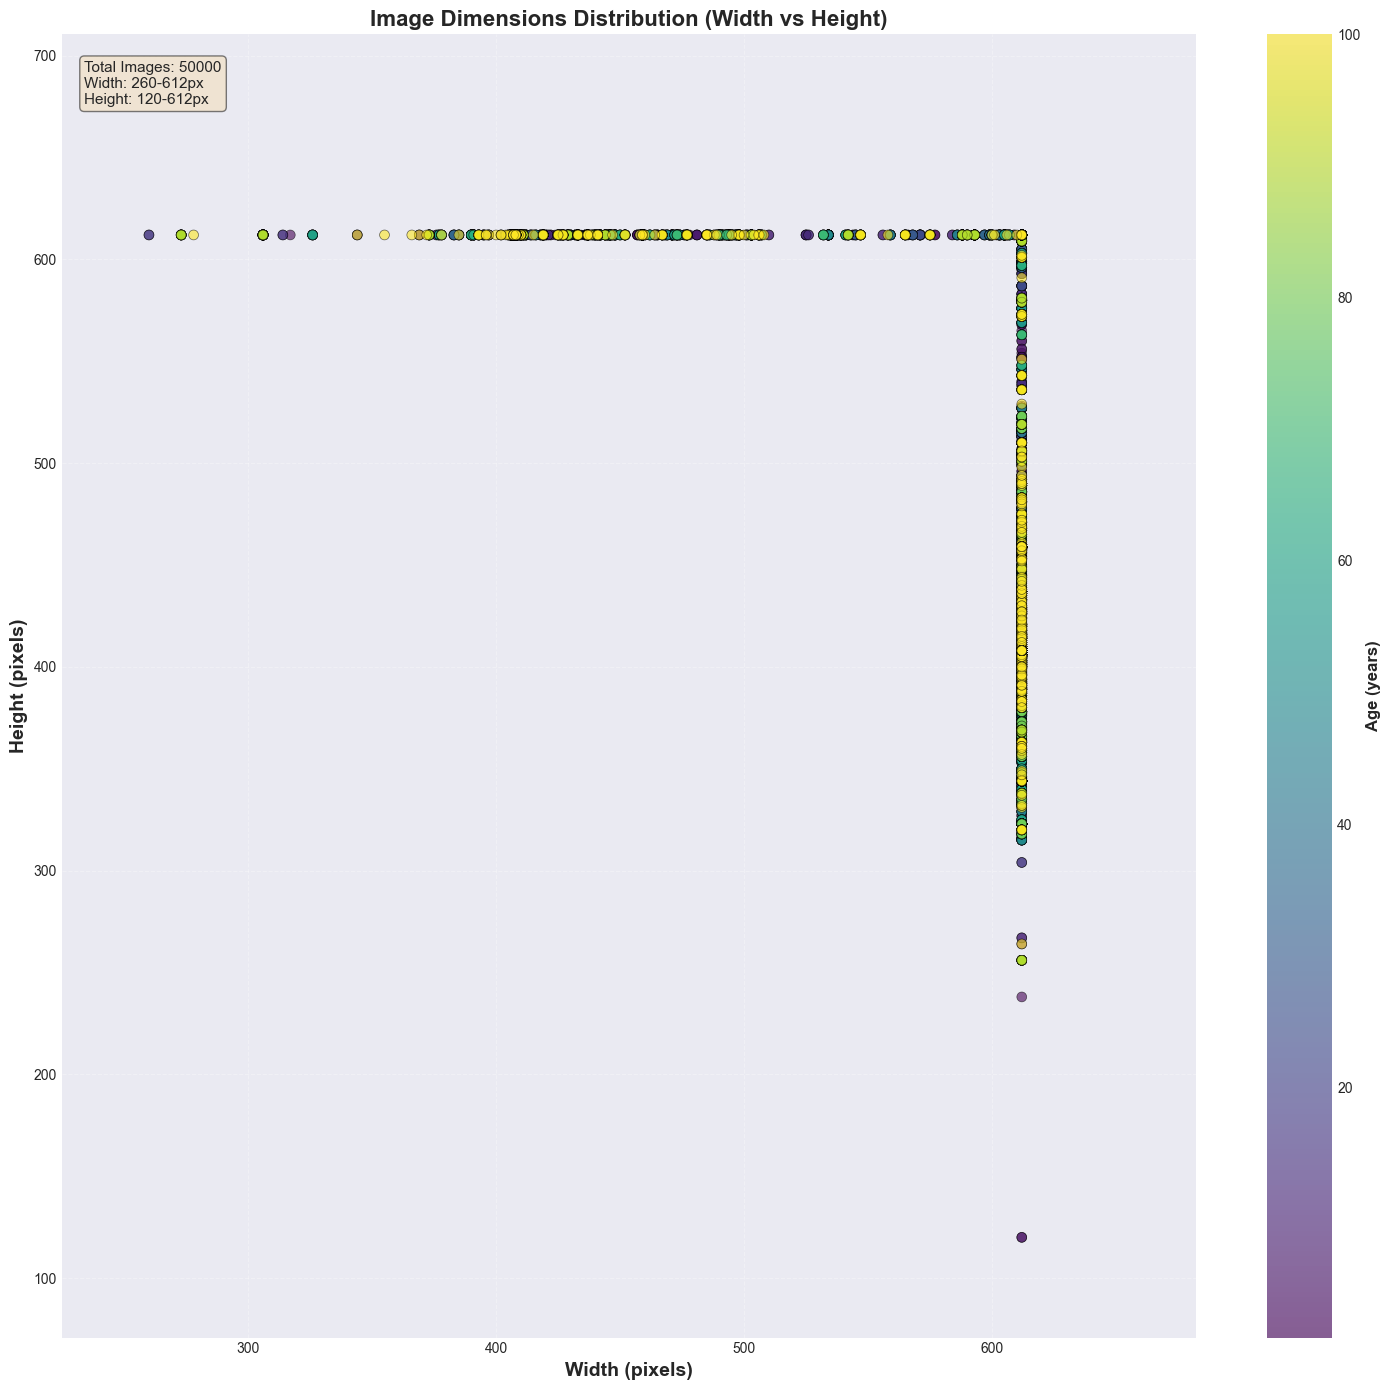

In [4]:
# Thiết lập style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Vẽ scatter plot: Width vs Height
fig, ax = plt.subplots(figsize=(15, 14))

# Scatter plot với màu theo độ tuổi
scatter = ax.scatter(size_df['width'], size_df['height'], 
                     c=size_df['age'], cmap='viridis', 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Width (pixels)', fontsize=14, fontweight='bold')
ax.set_ylabel('Height (pixels)', fontsize=14, fontweight='bold')
ax.set_title('Image Dimensions Distribution (Width vs Height)', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Tăng giá trị max của trục x và y để các điểm không nằm sát biên
x_min, x_max = size_df['width'].min(), size_df['width'].max()
y_min, y_max = size_df['height'].min(), size_df['height'].max()

# Thêm 20% padding cho mỗi phía
x_range = x_max - x_min
y_range = y_max - y_min
ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.2 * x_range)
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)

# Thêm colorbar để hiển thị độ tuổi
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Age (years)', fontsize=12, fontweight='bold')

# Thêm thông tin thống kê
textstr = f'Total Images: {len(size_df)}\n'
textstr += f'Width: {x_min}-{x_max}px\n'
textstr += f'Height: {y_min}-{y_max}px'
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 5. Xử Lý Trùng Lặp Ảnh với pHash

In [5]:
# Import thêm thư viện cho pHash
from PIL import Image
import imagehash
from collections import defaultdict

print("Bắt đầu tính pHash cho tất cả ảnh...")
print("(Quá trình này có thể mất vài phút)\n")

Bắt đầu tính pHash cho tất cả ảnh...
(Quá trình này có thể mất vài phút)



In [6]:
# Tính pHash cho tất cả ảnh với tf.data để tăng tốc
def compute_phash(file_path):
    """
    Tính perceptual hash cho ảnh
    
    Args:
        file_path: Đường dẫn đến file ảnh
    
    Returns:
        phash string hoặc None nếu lỗi
    """
    try:
        img = Image.open(file_path)
        # Tính phash (perceptual hash)
        phash = str(imagehash.phash(img))
        return phash
    except Exception as e:
        print(f"Lỗi khi tính hash cho {file_path}: {str(e)}")
        return None


# Dictionary để lưu: phash -> list của (filepath, age, folder)
phash_dict = defaultdict(list)

# Tính pHash cho từng ảnh
print("Đang tính pHash cho từng ảnh...")
for idx, row in tqdm(size_df.iterrows(), total=len(size_df), desc="Computing pHash"):
    filepath = row['filepath']
    age = row['age']
    
    # Tính pHash
    phash = compute_phash(filepath)
    
    if phash:
        # Lấy tên folder (age folder)
        folder = os.path.dirname(filepath)
        
        # Lưu vào dictionary
        phash_dict[phash].append({
            'filepath': filepath,
            'age': age,
            'folder': folder,
            'order': idx  # Thứ tự xuất hiện (để giữ ảnh đầu tiên)
        })

print(f"\n✓ Đã tính pHash cho {len(size_df)} ảnh")
print(f"✓ Tổng số pHash duy nhất: {len(phash_dict)}")
print(f"✓ Số lượng ảnh trùng lặp tiềm năng: {len(size_df) - len(phash_dict)}")

Đang tính pHash cho từng ảnh...


Computing pHash: 100%|██████████| 50000/50000 [01:23<00:00, 598.40it/s]


✓ Đã tính pHash cho 50000 ảnh
✓ Tổng số pHash duy nhất: 11187
✓ Số lượng ảnh trùng lặp tiềm năng: 38813


In [7]:
# Tìm và phân tích các ảnh trùng lặp
duplicates_info = []
indices_to_remove = []  # Lưu các index cần xóa trong DataFrame

print("Đang phân tích ảnh trùng lặp...")
for phash, images in phash_dict.items():
    if len(images) > 1:  # Có trùng lặp
        # Sắp xếp theo thứ tự xuất hiện (giữ ảnh đầu tiên)
        images_sorted = sorted(images, key=lambda x: x['order'])
        
        # Ảnh đầu tiên sẽ được giữ lại
        kept_image = images_sorted[0]
        
        # Các ảnh còn lại sẽ bị xóa khỏi DataFrame
        for img in images_sorted[1:]:
            indices_to_remove.append(img['order'])  # Lưu index thay vì filepath
            
            duplicates_info.append({
                'phash': phash,
                'kept_file': kept_image['filepath'],
                'kept_age': kept_image['age'],
                'kept_folder': kept_image['folder'],
                'duplicate_file': img['filepath'],
                'duplicate_age': img['age'],
                'duplicate_folder': img['folder']
            })

# Tạo DataFrame để phân tích
duplicates_df = pd.DataFrame(duplicates_info)

print(f"\n{'='*60}")
print(f"PHÂN TÍCH ẢNH TRÙNG LẶP")
print(f"{'='*60}")
print(f"\n📊 Tổng quan:")
print(f"   - Tổng số ảnh: {len(size_df)}")
print(f"   - Số ảnh duy nhất: {len(phash_dict)}")
print(f"   - Số ảnh trùng lặp: {len(indices_to_remove)}")
print(f"   - Tỷ lệ trùng lặp: {len(indices_to_remove)/len(size_df)*100:.2f}%")

if len(duplicates_df) > 0:
    print(f"\n📁 Phân tích theo folder:")
    
    # Đếm số lượng trùng lặp giữa các folder
    cross_folder_duplicates = duplicates_df[
        duplicates_df['kept_folder'] != duplicates_df['duplicate_folder']
    ]
    same_folder_duplicates = duplicates_df[
        duplicates_df['kept_folder'] == duplicates_df['duplicate_folder']
    ]
    
    print(f"   - Trùng lặp giữa các folder: {len(cross_folder_duplicates)}")
    print(f"   - Trùng lặp trong cùng folder: {len(same_folder_duplicates)}")
    
    # Hiển thị mẫu
    print(f"\n📋 Mẫu ảnh trùng lặp (5 trường hợp đầu):")
    print(duplicates_df[['kept_file', 'kept_age', 'duplicate_file', 'duplicate_age']].head())

print(f"\n{'='*60}")

Đang phân tích ảnh trùng lặp...

PHÂN TÍCH ẢNH TRÙNG LẶP

📊 Tổng quan:
   - Tổng số ảnh: 50000
   - Số ảnh duy nhất: 11187
   - Số ảnh trùng lặp: 38813
   - Tỷ lệ trùng lặp: 77.63%

📁 Phân tích theo folder:
   - Trùng lặp giữa các folder: 38805
   - Trùng lặp trong cùng folder: 8

📋 Mẫu ảnh trùng lặp (5 trường hợp đầu):
                               kept_file  kept_age  \
0  data\getty_images_raw\001\001_046.jpg         1   
1  data\getty_images_raw\001\001_046.jpg         1   
2  data\getty_images_raw\001\001_141.jpg         1   
3  data\getty_images_raw\001\001_141.jpg         1   
4  data\getty_images_raw\001\001_176.jpg         1   

                          duplicate_file  duplicate_age  
0  data\getty_images_raw\006\006_498.jpg              6  
1  data\getty_images_raw\007\007_498.jpg              7  
2  data\getty_images_raw\002\002_326.jpg              2  
3  data\getty_images_raw\003\003_318.jpg              3  
4  data\getty_images_raw\002\002_078.jpg              2  



In [8]:
# Cập nhật DataFrame và CSV sau khi loại bỏ trùng lặp
print("Đang cập nhật DataFrame và CSV dataset...")

# Loại bỏ các entry trùng lặp khỏi DataFrame (không xóa file ảnh)
remaining_files = size_df.drop(indices_to_remove).copy()

print(f"\n📊 Thống kê sau khi loại bỏ trùng lặp:")
print(f"   - Số ảnh ban đầu: {len(size_df)}")
print(f"   - Số ảnh còn lại: {len(remaining_files)}")
print(f"   - Số entry đã loại bỏ: {len(indices_to_remove)}")
print(f"\n⚠️ Lưu ý: Chỉ loại bỏ entry trong DataFrame, không xóa file ảnh vật lý")

# Lưu lại CSV mới
output_csv_path = csv_path.replace('.csv', '_no_duplicates.csv')
remaining_files.to_csv(output_csv_path, index=False)
print(f"\n✓ Đã lưu CSV mới tại: {output_csv_path}")

# Cập nhật lại size_df
size_df = remaining_files.copy()
print(f"✓ Đã cập nhật DataFrame size_df với {len(size_df)} ảnh")

Đang cập nhật DataFrame và CSV dataset...

📊 Thống kê sau khi loại bỏ trùng lặp:
   - Số ảnh ban đầu: 50000
   - Số ảnh còn lại: 11187
   - Số entry đã loại bỏ: 38813

⚠️ Lưu ý: Chỉ loại bỏ entry trong DataFrame, không xóa file ảnh vật lý

✓ Đã lưu CSV mới tại: data/getty_images_raw/getty_images_dataset_no_duplicates.csv
✓ Đã cập nhật DataFrame size_df với 11187 ảnh


## 7. Face Detection và Crop Ảnh

In [12]:
# Import thư viện face detection
import cv2
import urllib.request

# Kích thước tối thiểu cho ảnh crop
MIN_WIDTH = 224
MIN_HEIGHT = 224

# Download YuNet model nếu chưa có
model_path = 'face_detection_yunet_2023mar.onnx'
if not os.path.exists(model_path):
    print("Đang download YuNet model...")
    url = 'https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx'
    urllib.request.urlretrieve(url, model_path)
    print(f"✓ Đã download model vào: {model_path}")

# Load YuNet face detector
face_detector = cv2.FaceDetectorYN.create(
    model_path,
    "",
    (320, 320),
    score_threshold=0.6,
    nms_threshold=0.3
)

print(f"✓ Đã load YuNet face detector")
print(f"Min size cho ảnh crop: {MIN_WIDTH}x{MIN_HEIGHT}")

✓ Đã load YuNet face detector
Min size cho ảnh crop: 224x224


In [13]:
def detect_and_crop_face(image_path, target_size=(224, 224), margin=0.3):
    """
    Detect -> Square Crop -> Add Margin -> Resize
    margin=0.3 nghĩa là lấy thêm 30% ngữ cảnh (tóc, cổ)
    """
    try:
        img = cv2.imread(image_path)
        if img is None: return None
        
        h_img, w_img = img.shape[:2]
        
        # YuNet Setup
        face_detector.setInputSize((w_img, h_img))
        _, faces = face_detector.detect(img)
        
        # 1. Chỉ lấy ảnh có ĐÚNG 1 mặt
        if faces is None or len(faces) != 1:
            return None
            
        # Lấy tọa độ mặt
        face = faces[0]
        x, y, w, h = int(face[0]), int(face[1]), int(face[2]), int(face[3])
        
        # --- BỘ LỌC 1: KÍCH THƯỚC ---
        # Nếu mặt quá bé, vứt luôn. 
        # Với input model 224, mặt gốc ít nhất phải đạt 1/4 đến 1/3 kích thước đó.
        MIN_FACE_SIZE = 64 
        if w < MIN_FACE_SIZE or h < MIN_FACE_SIZE:
            return None
        
        # --- BƯỚC CẢI TIẾN: VUÔNG HÓA & CĂN GIỮA ---
        # Tìm tâm của khuôn mặt
        center_x = x + w // 2
        center_y = y + h // 2
        
        # Lấy cạnh lớn nhất để đảm bảo bao trọn mặt
        max_dim = max(w, h)
        
        # Tính cạnh của hình vuông sau khi thêm margin
        # Margin 0.3 dãn đều ra các phía để lấy tóc và cằm/cổ
        side_length = int(max_dim * (1 + margin))
        
        # Tính tọa độ mới (x1, y1) của hình vuông
        x1 = center_x - side_length // 2
        y1 = center_y - side_length // 2
        x2 = x1 + side_length
        y2 = y1 + side_length
        
        # --- XỬ LÝ BIÊN (PADDING ĐEN NẾU CẦN) ---
        # Nếu crop lòi ra ngoài ảnh, ta không thu hẹp box (vì sẽ mất context)
        # Mà ta sẽ pad màu đen vào phần thiếu.
        
        # Tính phần bù (padding) nếu tọa độ âm hoặc vượt quá ảnh
        pad_top = max(0, -y1)
        pad_bottom = max(0, y2 - h_img)
        pad_left = max(0, -x1)
        pad_right = max(0, x2 - w_img)
        
        # Nếu cần padding (tức là mặt nằm sát mép ảnh)
        if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
            # Tạo ảnh border
            img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0,0,0])
            # Cập nhật lại tọa độ crop (do ảnh đã to ra)
            x1 += pad_left
            y1 += pad_top
            x2 += pad_left
            y2 += pad_top
            
        # Crop ảnh vuông
        cropped = img[y1:y2, x1:x2]
        
        # --- RESIZE AN TOÀN ---
        # Vì cropped đã là hình vuông, resize sẽ không bị méo
        cropped_final = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
        
        return cropped_final

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [14]:
# Tạo thư mục cho ảnh đã crop
CROPPED_OUTPUT_DIR = 'data/getty_images_cropped'
os.makedirs(CROPPED_OUTPUT_DIR, exist_ok=True)

# Sử dụng dataset đã làm sạch (nếu có) hoặc dataset gốc
if 'remaining_files' in locals() and len(remaining_files) > 0:
    process_df = remaining_files.copy()
    print("Sử dụng dataset đã làm sạch (sau khi loại bỏ trùng lặp)")
else:
    process_df = size_df.copy()
    print("Sử dụng dataset gốc")

print(f"Số lượng ảnh cần xử lý: {len(process_df)}")
print(f"Output directory: {CROPPED_OUTPUT_DIR}")

Sử dụng dataset đã làm sạch (sau khi loại bỏ trùng lặp)
Số lượng ảnh cần xử lý: 11187
Output directory: data/getty_images_cropped


In [15]:
# Xử lý crop ảnh cho toàn bộ dataset
cropped_data = []
no_face_count = 0
multiple_faces_count = 0
success_count = 0
error_count = 0

print("Bắt đầu detect và crop khuôn mặt...")
print(f"Min size: {MIN_WIDTH}x{MIN_HEIGHT}")
print("⚠ Chỉ xử lý ảnh có ĐÚNG 1 khuôn mặt\n")

for idx, row in tqdm(process_df.iterrows(), total=len(process_df), desc="Processing faces"):
    filepath = row['filepath']
    age = row['age']
    
    # Đọc ảnh và detect số lượng khuôn mặt
    img = cv2.imread(filepath)
    if img is not None:
        img_height, img_width = img.shape[:2]
        face_detector.setInputSize((img_width, img_height))
        _, faces = face_detector.detect(img)
        
        # Đếm số lượng khuôn mặt
        if faces is not None and len(faces) > 1:
            multiple_faces_count += 1
            continue  # Bỏ qua ảnh có nhiều khuôn mặt
    
    # Crop ảnh (chỉ xử lý nếu có đúng 1 khuôn mặt)
    # Sửa: truyền target_size như một tuple
    cropped_img = detect_and_crop_face(filepath, target_size=(MIN_WIDTH, MIN_HEIGHT))
    
    if cropped_img is not None:
        # Tạo tên file mới
        original_filename = os.path.basename(filepath)
        age_folder = f'{age:03d}'
        
        # Tạo folder cho age nếu chưa có
        age_output_dir = os.path.join(CROPPED_OUTPUT_DIR, age_folder)
        os.makedirs(age_output_dir, exist_ok=True)
        
        # Đường dẫn file mới
        new_filepath = os.path.join(age_output_dir, original_filename)
        
        # Lưu ảnh đã crop
        cv2.imwrite(new_filepath, cropped_img)
        
        # Lưu thông tin
        relative_path = os.path.relpath(new_filepath, start='.').replace('\\', '/')
        cropped_data.append({
            'filepath': relative_path,
            'original_filepath': filepath,
            'age': age
        })
        success_count += 1
    else:
        no_face_count += 1

# Tạo DataFrame
cropped_df = pd.DataFrame(cropped_data)

print(f"\n{'='*60}")
print(f"KẾT QUẢ FACE DETECTION VÀ CROP")
print(f"{'='*60}")
print(f"✓ Xử lý thành công (1 khuôn mặt): {success_count} ảnh")
print(f"⚠ Không tìm thấy khuôn mặt: {no_face_count} ảnh")
print(f"⚠ Bỏ qua (nhiều khuôn mặt): {multiple_faces_count} ảnh")
print(f"✗ Lỗi: {error_count} ảnh")
print(f"\nTỷ lệ thành công: {success_count/len(process_df)*100:.2f}%")
print(f"Tỷ lệ bỏ qua (nhiễu): {(no_face_count + multiple_faces_count)/len(process_df)*100:.2f}%")
print(f"{'='*60}")

Bắt đầu detect và crop khuôn mặt...
Min size: 224x224
⚠ Chỉ xử lý ảnh có ĐÚNG 1 khuôn mặt



Processing faces: 100%|██████████| 11187/11187 [04:43<00:00, 39.41it/s]


KẾT QUẢ FACE DETECTION VÀ CROP
✓ Xử lý thành công (1 khuôn mặt): 5433 ảnh
⚠ Không tìm thấy khuôn mặt: 1913 ảnh
⚠ Bỏ qua (nhiều khuôn mặt): 3841 ảnh
✗ Lỗi: 0 ảnh

Tỷ lệ thành công: 48.57%
Tỷ lệ bỏ qua (nhiễu): 51.43%


In [16]:
# Lưu dataset đã crop
cropped_csv_path = 'data/getty_images_cropped/dataset_cropped.csv'
cropped_df.to_csv(cropped_csv_path, index=False)

print(f"✓ Đã lưu dataset cropped vào: {cropped_csv_path}")
print(f"\n📊 Phân bố theo độ tuổi (ảnh đã crop):")
print(cropped_df['age'].value_counts().sort_index())

# Thống kê kích thước
print(f"\n📏 Tất cả ảnh đã được resize về: {MIN_WIDTH}x{MIN_HEIGHT}")

✓ Đã lưu dataset cropped vào: data/getty_images_cropped/dataset_cropped.csv

📊 Phân bố theo độ tuổi (ảnh đã crop):
age
1      200
2      168
3        6
4      197
6      213
8      247
10     215
12     229
14     191
16     203
18     191
20     240
25     283
30     288
35     301
40     273
45     282
50     243
55     231
60     269
65     258
70     183
80     182
90     218
100    122
Name: count, dtype: int64

📏 Tất cả ảnh đã được resize về: 224x224


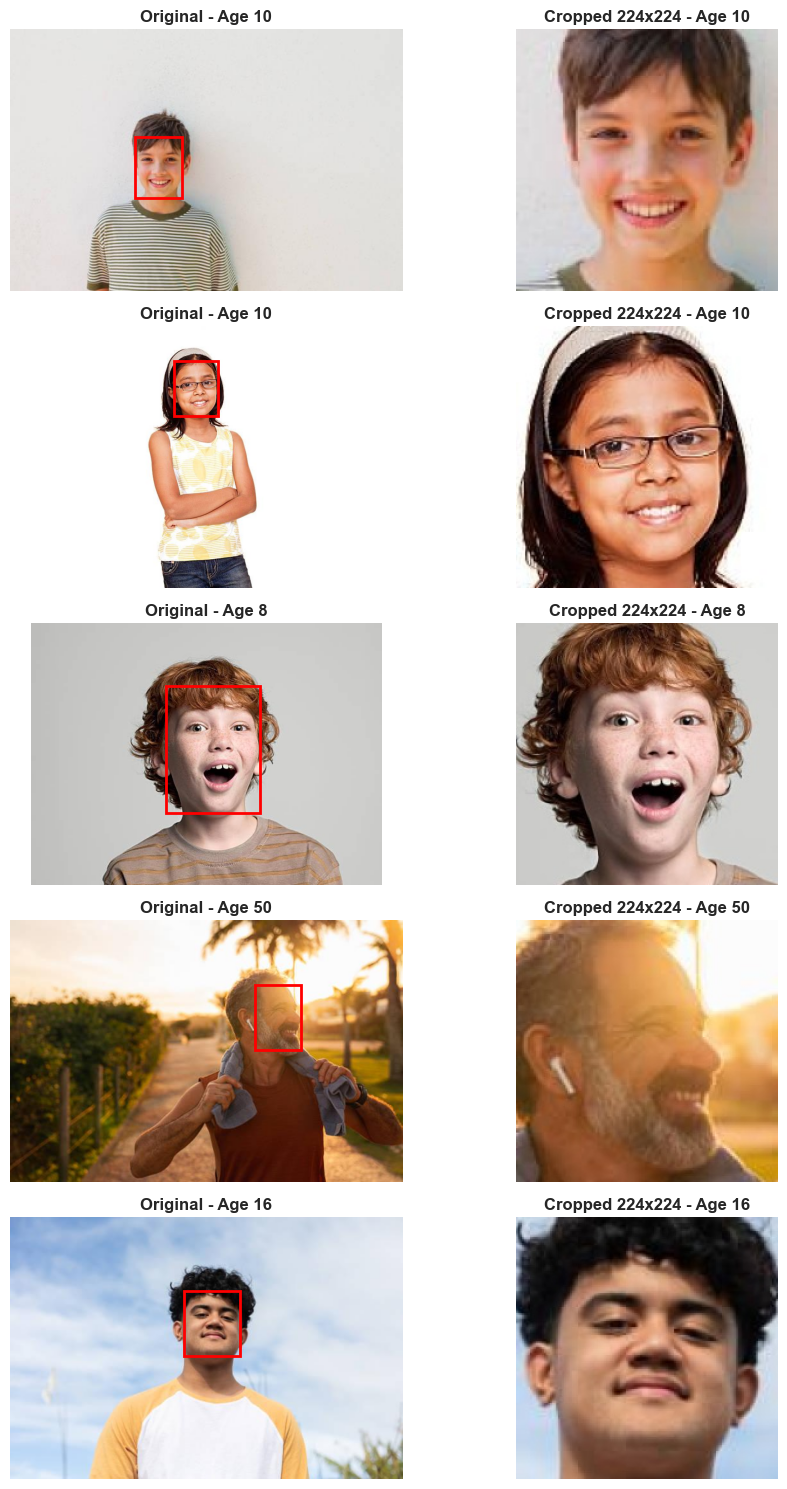


✓ Đã lưu biểu đồ so sánh vào: data/getty_images_cropped/before_after_crop.png


In [17]:
# Hiển thị mẫu ảnh trước và sau khi crop
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Chọn ngẫu nhiên 5 ảnh để hiển thị
sample_indices = np.random.choice(len(cropped_df), min(5, len(cropped_df)), replace=False)

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, idx in enumerate(sample_indices):
    original_path = cropped_df.iloc[idx]['original_filepath']
    cropped_path = cropped_df.iloc[idx]['filepath']
    age = cropped_df.iloc[idx]['age']
    
    # Đọc ảnh gốc
    original_img = cv2.imread(original_path)
    if original_img is not None:
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Detect face để vẽ bounding box (dùng YuNet)
        img_h, img_w = original_img.shape[:2]
        face_detector.setInputSize((img_w, img_h))
        _, faces = face_detector.detect(cv2.imread(original_path))
        
        # Hiển thị ảnh gốc với bounding box
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Original - Age {age}', fontweight='bold')
        axes[i, 0].axis('off')
        
        # Vẽ bounding box nếu tìm thấy khuôn mặt
        if faces is not None and len(faces) > 0:
            x, y, w, h = int(faces[0][0]), int(faces[0][1]), int(faces[0][2]), int(faces[0][3])
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            axes[i, 0].add_patch(rect)
    
    # Đọc ảnh đã crop
    cropped_img = cv2.imread(cropped_path)
    if cropped_img is not None:
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        axes[i, 1].imshow(cropped_img)
        axes[i, 1].set_title(f'Cropped {MIN_WIDTH}x{MIN_HEIGHT} - Age {age}', fontweight='bold')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('data/getty_images_cropped/before_after_crop.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu biểu đồ so sánh vào: data/getty_images_cropped/before_after_crop.png")

## 8. Phân Tích Kích Thước Ảnh Sau Khi Crop

In [18]:
# Phân tích kích thước ảnh sau khi crop
cropped_sizes = []

print("Đang phân tích kích thước ảnh đã crop...")
for idx, row in tqdm(cropped_df.iterrows(), total=len(cropped_df), desc="Analyzing cropped images"):
    filepath = row['filepath']
    age = row['age']
    
    try:
        # Đọc ảnh để lấy kích thước thực tế
        img = cv2.imread(filepath)
        if img is not None:
            height, width = img.shape[:2]
            cropped_sizes.append({
                'filepath': filepath,
                'age': age,
                'height': height,
                'width': width
            })
    except Exception as e:
        print(f"Lỗi khi đọc {filepath}: {str(e)}")

# Tạo DataFrame
cropped_size_df = pd.DataFrame(cropped_sizes)

print(f"\n✓ Đã phân tích {len(cropped_size_df)} ảnh")
print(f"\n📊 Thống kê kích thước:")
print(f"   - Width: min={cropped_size_df['width'].min()}, max={cropped_size_df['width'].max()}")
print(f"   - Height: min={cropped_size_df['height'].min()}, max={cropped_size_df['height'].max()}")

Đang phân tích kích thước ảnh đã crop...


Analyzing cropped images: 100%|██████████| 5433/5433 [00:25<00:00, 213.41it/s]


✓ Đã phân tích 5433 ảnh

📊 Thống kê kích thước:
   - Width: min=224, max=224
   - Height: min=224, max=224
